In [147]:
import re
import urllib.request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import datetime

# page nos. 1 to 1539
persian_steingass_url = 'https://dsal.uchicago.edu/cgi-bin/app/steingass_query.py?page={}'

In [164]:
def getSteingassPage(page):
    with urllib.request.urlopen(persian_steingass_url.format(page)) as response:
        html = response.read()
        html = html.decode('utf-8')
    bs = BeautifulSoup(html)
    df = DataFrame([{
            'def': re.sub(r'^\s*,', '', ' '.join(sib.text.strip() 
                for sib in hw.next_siblings)).strip(),
            'pa': hw.pa.string,
            'ro': hw.i.string if hw.i else None,
            'lang': hw.parent.lang.string if hw.parent.lang else None,
            'page': page
            } for hw in bs.find_all('hw')])
    if len(df) == 0:
        return df
    else:
        return df[['pa', 'ro', 'def', 'lang', 'page']]

In [167]:
DON'T RERUN

pages = []

for page in range(1, 1540):
    print('=', end='')
    if page % 5 == 0:
        print('|', end='')
        if page % 50 == 0:
            print(page, datetime.datetime.now())
    pages.append(getSteingassPage(page))

FullDict = pd.concat(pages)

FullDict.to_csv('steingass.csv')

=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|50 2022-02-01 16:26:58.036586
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|100 2022-02-01 16:27:21.014403
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|150 2022-02-01 16:27:43.881089
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|200 2022-02-01 16:28:06.828299
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|250 2022-02-01 16:28:29.706483
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|300 2022-02-01 16:28:52.504979
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|350 2022-02-01 16:29:15.890356
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|400 2022-02-01 16:29:38.687039
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|450 2022-02-01 16:30:01.519369
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|500 2022-02-01 16:30:24.174948
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|550 2022-02-01 16:30:46.884391


,pa,ro,def,lang,page
0,ا,alif,the first letter of the Arabic and Persian alp...,None,1
1,آ,ā,(S. ā ) Preposition inseparably joined to verb...,None,1
0,آب,āb,"(S. ap ) Water; river; largesse, gift, price; ...",None,3
1,آب,āb,"(in Zand and Pāzand), Father.",None,3
2,آب,āb,The Syro-Macedonian month of August.,A,3
...,...,...,...,...,...
11,ی‍ﮩ‍ی‍ﮩ‍ة,"yahyahat, yahyahah",Calling to camels yāh yāh.,A,1539
12,یئس,yaʼis,"Despondent, despairing.",A,1539
13,ییعث,yaiʻus̤,A district of moving sands in Arabia Felix dan...,A,1539
14,ییلا,yailā,Summer-quarters.,T,1539


In [275]:
FullDict = pd.read_csv('steingass.csv')

FullDict['def_len'] = FullDict['def'].str.len()
FullDict['subdef_count'] = FullDict['def'].fillna('').apply(lambda d: len(d.split('—')))

<AxesSubplot:>

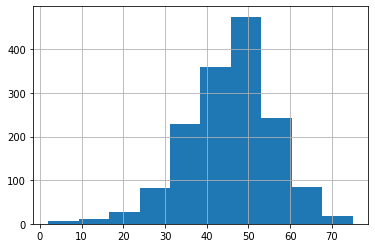

In [270]:
#Entries per page
FullDictCsv.page.value_counts().hist()

In [271]:
# missings pages are all due to continuations of long entries, grouped withfollowing pages

for p in range(1, 1540):
    if not p in list(FullDictCsv.page):
        print(p)

2
41
486
520
665
666


In [272]:
# Length of definitions varies a lot

FullDict['def'].str.len().describe()

count    69887.000000
mean        78.844864
std        185.667425
min          2.000000
25%         22.000000
50%         39.000000
75%         82.000000
max      17483.000000
Name: def, dtype: float64

In [276]:
# top words by definition length

'; '.join(list(FullDict.sort_values('def_len', ascending=False)[:180].ro))

'sar; dast; āb; ḵẖẉush, ḵẖẉash; az; sang; ḵẖat̤t̤; ahl; gil; kār; chashm; yāʼ, yā; ʻalm; dandān; ḥarf; ṣāḥib; g̠ẖair; rāh; ātish; ḵẖūd; ḵẖūn; īn; rawī; marg̠ẖ; zabān, zubān; dil; gosh; ḥaqq, ḥaq; nān; tīr; faʻl; kashīdan; rang; parda; bād; zar; dāman; ʻalá; suḵẖun, suḵẖan, saḵẖan, saḵẖun; dam; roz; ḵẖāna; pusht; gard; kulāh; jāma; h; teg̠ẖ; dar; ḵẖāk; ʻain; ʻarẓ; bāz; daryā; pāy; angusht; jān; naqsh; ḵẖẉāb; taḵẖt; sher; giriftan; nafs; shāḵẖ; dāg̠ẖ; band; lab; ʻanān; shab; qat̤ʻ; taḵẖta; zīr, zer; pas; qadm; chashma; kāsa; ḵẖam; qalb; ʻālam; dār; gara; kamar; chūb, chob; pesh; āyina; rishta; jamʻ; husn; naql; y; chirāg̠ẖ; kāmān; jām; ganj; māh; naz̤r; ism; charḵẖ; tuḵẖm; panja; t̤arf; bār; nāma; kāg̠ẖaẕ, kāg̠ẖiẕ; mail; pīr; naʻl; ʻarq; diraḵẖt; qabl; ḵẖār; qaẓā; māl; nāḵẖun; ḥurūf; sharāb; kala; dīda; ḥukm; raish; dard; bar sar; nām; kashtī; shamsher; zamīn; qafl; man; nishān; ban; gāu, gāo, gāv; par, parr; warq; ḥalqat, ḥalqa; m; baḥr; ashk; kardan; cha; qūwat, quwwat; raug̠ẖan; abū; 

In [282]:
# top words by subdefinition count

'; '.join(list(FullDict.sort_values('subdef_count', ascending=False)[:180].ro.fillna('!!!')))

'sar; dast; āb; ḵẖẉush, ḵẖẉash; ahl; az; sang; gil; ḵẖat̤t̤; ʻalm; ṣāḥib; g̠ẖair; ḥarf; rāh; kār; dandān; chashm; ḵẖūd; ātish; īn; ḵẖūn; rawī; dil; marg̠ẖ; zar; zabān, zubān; kashīdan; nān; ʻalá; ḥaqq, ḥaq; bād; parda; gosh; ḵẖāna; suḵẖun, suḵẖan, saḵẖan, saḵẖun; faʻl; roz; dam; rang; dāman; sher; pusht; daryā; dār; tīr; ḵẖẉāb; ḵẖāk; pas; ism; diraḵẖt; jāma; pāy; teg̠ẖ; shab; giriftan; gard; zīr, zer; lab; angusht; ʻālam; jān; ʻanān; kāsa; chūb, chob; husn; dar; taḵẖta; ḥurūf; chashma; pesh; dard; naqsh; kāmān; kulāh; raug̠ẖan; tuḵẖm; māh; chirāg̠ẖ; qadm; shāḵẖ; kardan; bāz; qūwat, quwwat; gara; māl; bilā (bi-lā); dīda; qat̤ʻ; āyina; taḵẖt; sharāb; nafs; kashtī; shamʻ; pīr; zamīn; abū; ḵẖār; rishta; dāg̠ẖ; jauhar; baḥr; waqt; cha; zadan; har; jām; ḵẖam; āstīn; jāy; arbāb; !!!; bāg̠ẖ; ḥamá; ʻain; nām; jamʻ; ʻarq; ganj; gāu, gāo, gāv; ḥukm; ʻuẓlat; panja; ḥalqat, ḥalqa; kamar; rag; nāḵẖun; ashk; bar sar; ʻand, ʻind, ʻund; qalm; chādar; ban; charḵẖ; mā; koh, kūh; nihādan; man; ẕī; tā; bur

In [286]:
[d.split('—')[1:] for d in FullDict['def'].fillna('')]

[[' اَ  a , at the beginning of some Persian words, denotes privation, as /?/ ajum-bān , Motionless. Prefixed to an Arabic sentence, it serves as a particle of interrogation, as in the Coranic phrase alastu bi-rabbi-kum , "Am I not your Lord?" whence the Persian روز الست  rozi alast , q.v. At the end of Persian words it marks the vocative, as in shāhā , O Shah, or it serves as a prosodial expletive in poetry, notably in the oldest parts of Firdausi\'s great poem.'],
 [' (Imperative and contracted participle of āmadan, āʼīdan ) Come.'],
 [' ābi ābistan (pregnant water), Tears of a lover, wine, blood ( ābi ābistanī dādan , To fertilize ground); ',
  ' ābi ātish-rang or ābi ātish-zāy , Wine; tears of grief or anger; ',
  ' ābi ātish zadah , Tears; ',
  ' āb ātish shud , The water boiled; a tumult was raised; ',
  ' ābi ātish-mizāj , Red wine; ',
  ' ābi ātish-numāy , Wine; tears of grief; ',
  ' ābi ātishnāk , Red wine; ',
  ' ābi ātishīn , Wine; tears of blood; ',
  ' ābi ājām , Water st

In [283]:
FullDict[FullDict.ro.isnull()].sort_values('def_len', ascending=False)

,Unnamed: 0,pa,ro,def,lang,page,def_len,subdef_count
62009,23,مير,NaN,"(for A. امير ), An emperor, prince, lord, gove...",a,1360,1244.0,23
39207,8,ع ʻ,NaN,called ʻaini g̠ẖair manqūt̤a or ʻaini muhmala ...,NaN,828,732.0,1
37267,46,ص,NaN,The seventeenth letter of the Arabic-Persian a...,NaN,777,514.0,1
30662,54,س,NaN,"called sīni g̠ẖair manqūt̤a, sīni muhmala , Un...",NaN,637,277.0,1
68463,21,همز,NaN,"(v.n.), Squeezing (in the hand); making a sign...",A,1510,260.0,2
15676,14,تععيل,NaN,"Causing to be unemployed; rendering vacant, vo...",A,309,246.0,2
1007,26,اختلال,NaN,"Being lean, emaciated; standing in need; sewin...",A,24,218.0,3
5387,19,انشاز,NaN,Raising (anything) from its place; collecting ...,A,111,154.0,1
49127,6,گاو نبطونك,NaN,"(?), (in the dialect of Shīrāz) A kind of spur...",NaN,1074,121.0,1
62649,27,ناشبسته,NaN,"(?), Unwashed (the word given by Meninsky is e...",NaN,1373,92.0,1


In [232]:
FullDict.fillna('_').lang.value_counts() #.plot.pie()

_        35328
A        25321
a         8141
T          386
G          258
H          150
t          111
SY          38
M           28
a t         26
h           14
L           10
g a          9
S            9
E            9
R            8
t a          6
g            6
ā            5
P            5
a h          3
m            3
A P          2
B            1
SP           1
o            1
a p t        1
SY.          1
HE           1
H.           1
PORT.        1
A G          1
U            1
A T          1
r            1
Name: lang, dtype: int64

In [268]:
FullDictCsv['def'].fillna('').str.split('—').apply(len)

0          2
1          2
2        175
3          1
4          1
        ... 
69883      1
69884      1
69885      1
69886      1
69887      1
Name: def, Length: 69888, dtype: int64

In [165]:
getSteingassPage(24)

,pa,ro,def,lang,page
0,اخترام,iḵẖtirām,"Tearing; destroying, extirpating; cutting off,...",A,24
1,اخترسپاه,aḵẖtar-sipāh,A sovereign whose army is numerous as the stars.,None,24
2,اخترستان,aḵẖtaristān,Name of a treatise on astronomy.,None,24
3,اختر شمار,aḵẖtar-shumār,An astronomer.,None,24
4,اختر ضمير,aḵẖtar-ẓamīr,Of an enlightened mind; of a bright intellect.,a,24
5,اختر گراى,aḵẖtar-girāy,"Who examines the stars, investigates their cou...",None,24
6,اخترگو,aḵẖtar-go (gū),"An astrologer, augur.",None,24
7,اخترى,aḵẖtarī,"A diviner, soothsayer.",None,24
8,اختزاع,iḵẖtizāʻ,"Tearing away, alienating (one) from his kindred.",A,24
9,اختزال,iḵẖtizāl,"Tearing away, alienating from kindred; being a...",A,24


In [156]:
with urllib.request.urlopen(persian_steingass_url.format(24)) as response:
    html = response.read()
    html = html.decode('utf-8')
    bs = BeautifulSoup(html)

In [159]:
[{
    'def': [sib.text for sib in hw.next_siblings],
    'pa': hw.pa.string,
    'ro': hw.i.string if hw.i else None,
    'lang': hw.parent.lang.string if hw.parent.lang else None
    } for hw in bs.find_all('hw')]

[{'def': [' , Tearing; destroying, extirpating; cutting off, carrying off. \n\t\t\t'],
  'pa': 'اخترام',
  'ro': 'iḵẖtirām',
  'lang': 'A'},
 {'def': [' , A sovereign whose army is numerous as the stars. \n\t\t\t'],
  'pa': 'اخترسپاه',
  'ro': 'aḵẖtar-sipāh',
  'lang': None},
 {'def': [' , Name of a treatise on astronomy. \n\t\t\t'],
  'pa': 'اخترستان',
  'ro': 'aḵẖtaristān',
  'lang': None},
 {'def': [' , An astronomer. \n\t\t\t'],
  'pa': 'اختر شمار',
  'ro': 'aḵẖtar-shumār',
  'lang': None},
 {'def': [' , Of an enlightened mind; of a bright intellect. \n\t\t\t'],
  'pa': 'اختر ضمير',
  'ro': 'aḵẖtar-ẓamīr',
  'lang': 'a'},
 {'def': [' , Who examines the stars, investigates their course, astrologer. \n\t\t\t'],
  'pa': 'اختر گراى',
  'ro': 'aḵẖtar-girāy',
  'lang': None},
 {'def': [' , An astrologer, augur. \n\t\t\t'],
  'pa': 'اخترگو',
  'ro': 'aḵẖtar-go (gū)',
  'lang': None},
 {'def': [' , A diviner, soothsayer. \n\t\t\t'],
  'pa': 'اخترى',
  'ro': 'aḵẖtarī',
  'lang': None},
 {'d